In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime,timedelta
import helpers.cusplot as cplt
import scipy.optimize as sco
import scipy.constants as scc
from ionoptics import geometry as geo
from ionoptics import beamline as bl

from functools import partial
import scipy.signal as ss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## constants (SI)

In [ ]:
# general
c = 299792458
m_pr = 938.272 # MeV

# kicker
brho = 1.23 
lgap = 0.1
kick_l = 0.5
N = 20
u0 = 4*np.pi*1e-7

l = 3 # dist. kicker-septum

# charge distribution
sigma = 0.015
delta_x_max = 0.01

# septum
w = 0.005 # 5 mm thickness for DC septum (CERN paper)
# assuming infinte extend in y (valid - 100 mm beam tube > 6 sigma)

In [ ]:
# numeric integration of current fraction 
# incident on septum
d = {}

for delta_x in np.linspace(0,delta_x_max,10):
    I = 0
    for step in np.linspace(2*sigma-w/2, 2*sigma + w/2,10):
        I += np.exp(-(step-delta_x)**2/(2*sigma**2))*w/10
    
    I_norm = 1/(np.sqrt(2*np.pi)*sigma)*I
    
    d[delta_x] = I_norm

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(*zip(*sorted(d.items())))
ax.set_xlabel('delta x [m]')
ax.set_ylabel('fraction')

ax.set_title('int. fraction on {} mm septum'.format(w*1e3))

#convert spat. to curr_off
def dx_to_dI(dx):
    dThet = dx/l
    dI = brho*lgap/(u0*kick_l*N)*dThet
    return round(dI,3)

cplt.add_axis(ax, 'x', dx_to_dI, 'delta I [A]' )

plt.show()

## el. vs. magn. field

In [ ]:
# integrated B-field / E-field norm. to kick angle
M = 1 # 1:MeV, 1e-3: keV, ...

T = np.arange(0,100,10)* M# MeV
p = np.sqrt(T**2+2*T*m_pr) # MeV

mag = p*1e-3/0.3 * M

el = p/m_pr*c*p*1e-3/0.3 * M

ax = plt.gca()
ax.set_xlabel(r'$E$ [MeV]')
ax.set_xticks(T)
ax.set_ylabel(r'$BL/\Theta$ [Tm/rad]')
ax.set_title('electric vs. magnetic field')
ax1 = ax.twinx()
ax1.set_ylabel(r'$EL/\Theta$ [V/rad]')
ax1.spines['right'].set_color('r')

ax.plot(T,mag)
ax1.plot(T,el, c = 'r')
ax.legend(['int., norm. B-field'], loc = 2)
ax1.legend(['int., norm. E-field'], loc = 4)

plt.savefig('/home/marius/Jülich/Multiplexer/Plots/elvsmagn')
plt.show()

## beam tube induction - paper

In [ ]:
def B(t,f,tau,B0):
    w = 2*np.pi*f
    
    t0 = np.pi/w
    
    C1 = w*tau
    
    tleq = np.asarray([time for time in t if time <= t0])
    tgeq = np.asarray([time for time in t if time >= t0])
    
    Bleq = B0*(1/np.sqrt(1+C1**2)*np.sin(w*tleq-np.arctan(w*tau))+C1/(1+C1**2)*np.exp(-tleq/tau))
    Bgeq = B0*C1/(1+C1**2)*(1+np.exp(t0/tau))*np.exp(-tgeq/tau)
    
    return np.append(Bleq,Bgeq)

In [ ]:
sigma = 1.33e6 # S/m
a = 65e-3/2 # inner radius
d = 5e-3 # beam tube thickness

tau = scc.mu_0*sigma*a*d/2

fig,ax = plt.subplots(5,1,figsize = (5,20))

for i,f in enumerate([1e2,5e2,1e3,5e3,10e3]):

    w = 2*np.pi*f
    
    t0 = np.pi/w

    t = np.linspace(0,5*t0,1000)
    tleq = np.asarray([time for time in t if time <= t0])
    
    ax[i].plot(t,B(t,f,tau,50e-3))
    ax[i].plot(tleq,50e-3*np.sin(w*tleq))
    ax[i].text(0,0,'{:.2e}'.format(B(t,f,tau,50e-3).max()))
    ax[i].set_title('{:.1e}'.format(f))
    

PATH_TO_DATA = '../../Misc/'
FILENAME = 'beam_induction_sine_circular tube_{:.2e}_{:.2e}_{:.2e}'.format(sigma,a,d)
plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

In [ ]:
# from paper
t = np.linspace(0,7e-6,100)
plt.plot(t,B(t,0.125e6,1e-6,1))

## testing point-to-parallel w/ 7 quadrupoles (IBL - 1st section)

In [2]:
# distances

# point - to - parallel: M11 = 0, M33 = 0

# l1 - L_Fe - l1 - L_Fe - l1,l3,l1 - L_Fe - l2 - L_Fe - l2 - L_Fe - l1,l3,l1 - L_Fe - l1 - L_Fe - l1

L_Fe = 0.3
l1 = 0.3
l2 = 0.5
l3 = 0.97

# l1,l3,l1
l4 = 2*l1+l3

l5 = l1+l3

#TODO: need bl functions

In [7]:
# 7 quads Benat
k0,k1,k2,k3 = 0.286,1.697,2.442,5.275

In [6]:
lengths = [l1,L_Fe,l1,L_Fe,l1,l3,l1,L_Fe,l2,L_Fe,l2,L_Fe,l1,l3,l1,L_Fe,l1,L_Fe,l1]
elements = [bl.drift,bl.qdf,bl.drift,bl.qf,bl.drift,
            partial(bl.dipole, L_max = 0.97, alpha = 0.67, beta_s=0.18,beta_e=0.18),
            bl.drift,bl.qdf,bl.drift,bl.qf,bl.drift,bl.qdf,bl.drift,
            partial(bl.dipole, L_max = 0.97, alpha = 0.67, beta_s=0.18,beta_e=0.18),
            bl.drift,bl.qf,bl.drift,bl.qdf,bl.drift]

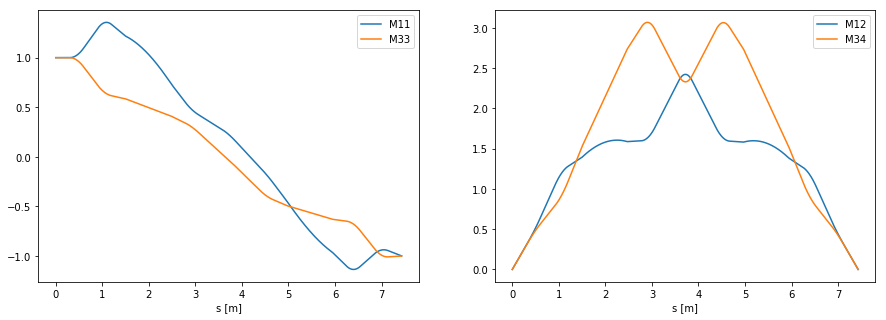

In [4]:
elements = bl.eles_to_peles(elements,bl.opt_quad_mult(elements,lengths),S=True)
bl.plot_M_vs_s(elements,lengths, figsize = (15,5))



plt.show()

In [7]:
bl.opt_quad_mult(elements,lengths)

array([2.1178545 , 2.59995479, 2.21822665, 3.16598974])

## testing point-to-parallel w/ NESP

In [2]:
# distances

# point - to - parallel: M11 = 0, M33 = 0

# l1 - L_Fe - l1 - L_Fe - l1,l3,l1 - L_Fe - l2 - L_Fe - l2 - L_Fe - l1,l3 - l4 - L_Fe - l5 - L_Fe - l6

L_Fe = 0.3
l1 = 0.3
l2 = 0.5
l3 = 0.97

l4 = 4.8
l5 = 0.9
l6 = 1.4+0.9

In [5]:
lengths = [l1,L_Fe,l1,L_Fe,l1,l3,l1,L_Fe,l2,L_Fe,l2,L_Fe,l1,l3,l4,L_Fe,l5,L_Fe,l6]
elements = [bl.drift,bl.qdf,bl.drift,bl.qf,bl.drift,
            partial(bl.dipole, L_max = 0.97, alpha = 0.67, beta_s=0.18, beta_e=0.18),
            bl.drift,bl.qdf,bl.drift,bl.qf,bl.drift,bl.qdf,bl.drift,
            bl.drift,
            bl.drift,bl.qf,bl.drift,bl.qdf,bl.drift]

vals = bl.opt_quad_mult(elements,lengths,'P-to-Par',S=False)
vals

array([2.20181443, 1.95877208, 2.10294043, 2.03020143, 2.09390808,
       1.82750886, 2.67880366])

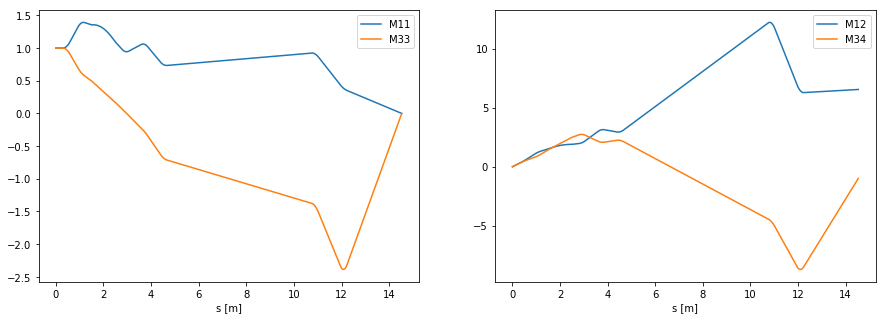

In [6]:
elements = bl.eles_to_peles(elements,vals,S=False)
bl.plot_M_vs_s(elements,lengths, figsize = (15,5))



plt.show()

In [ ]:
[]

## Multiplexer geometry BK

In [ ]:
x_sept = 4*7e-3
x_at_max_prop = 0.1
x_add = x_at_max_prop - x_sept
l_kick = 0.5
l_sept = 0.5
sept_type = 'DC'
start_kick = 0.001 # smallest kick-angle
step_kick = 0.001 # step size kick-angle

list_perm = np.linspace(0,1,1001) # range of septum anglesenvelope
max_prop = 2

ax,data = geo.plot_comb_kick_sept(x_sept, x_add, 0,0, l_kick, l_sept, sept_type, 
                        start_kick, step_kick, list_perm, max_prop, figsize = (15,5),brho=0.98)

plt.show()

In [ ]:
kick_d = data[0][0.3]

dks = [d[1] for d in data[1] if d[0] == kick_d]
dks_av = sum(dks)/len(dks)
# kicker-septum


dsf = [d[1] for d in data[2] if d[0] == kick_d]
dsf_av = sum(dsf)/len(dsf)
# septum - final

(kick_d,dks_av,dsf_av)

In [ ]:
0.032*0.98/0.5

### multiplexer pulse compositions

In [166]:
f_straight = np.arange(10,400,10)
T_straight = 1/f_straight
dc = 0.04

t_rise = 1e-3

In [167]:
t_defl = T_straight - dc*T_straight - 2*t_rise
f_defl = dc/t_defl

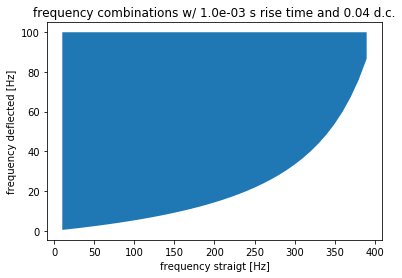

In [169]:
#plt.plot(f_straight,f_defl)

plt.fill_between(f_straight,f_defl,100)
plt.title('frequency combinations w/ {:.1e} s rise time and {} d.c.'.format(t_rise,dc))
plt.xlabel('frequency straigt [Hz]')
plt.ylabel('frequency deflected [Hz]')

plt.savefig(r'C:\Users\mrimm\Desktop\Vorträge\PHD_days_031219\freq_upgrade_bum.png', format = 'png', dpi=300)
plt.show()

In [3]:
dc = 0.04
risefall_1 = 12e-3
f_straight_1 = np.arange(5,50,1)
T_straight_1 = 1/f_straight_1
t_straight_1 = dc*T_straight_1

In [4]:
t_defl = T_straight_1-t_straight_1 - risefall_1

t_defl[t_defl >= 0.05] = 0.05

pos = (t_defl >= 0.015) & (t_defl <= 0.05)
t_defl_pos = [None]*len(pos)

for i,j in enumerate(pos):
    if j:
        t_defl_pos[i] = t_defl[i]
    else:
        t_defl_pos[i] = 0
        

        
f_defl = 0.25
dc_defl = [i*f_defl for i in t_defl_pos]

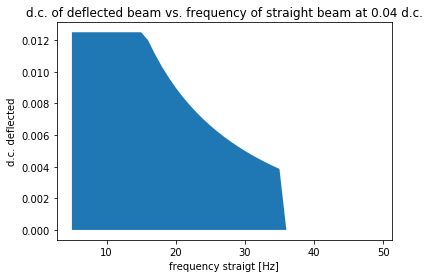

In [6]:
plt.fill_between(f_straight_1, dc_defl)

plt.title('d.c. of deflected beam vs. frequency of straight beam at 0.04 d.c.')
plt.xlabel('frequency straigt [Hz]')
plt.ylabel('d.c. deflected')

plt.savefig(r'C:\Users\mrimm\Desktop\Vorträge\PHD_days_031219\dc_deflected_0.25Hz.png', format = 'png', dpi=300)
plt.show()

### effective length bumper

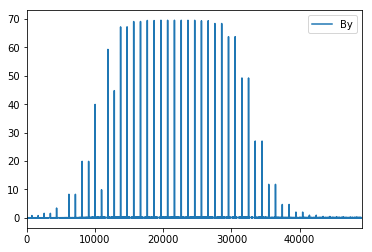

In [3]:
data = pd.read_csv(r'C:/Users/mrimm/Desktop/MISC/250A_1ms_50ms_10ms_length_full_2shots.txt',sep='\t')

data['Timestamp'] = data['Timestamp'].apply(lambda x: datetime.strptime(x[:26],'%Y.%m.%d %H:%M:%S.%f'))

data['By'] = data['By'].apply(lambda x: -x)

data.plot(y='By')

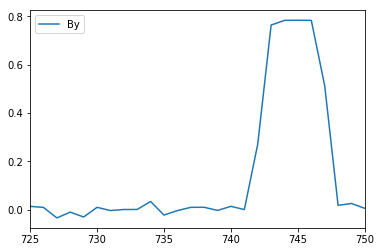

In [9]:
data.loc[725:750].plot(y='By')

In [61]:
start = - 520/2 - 405 + 135 # start in mm

rel = data[data['By'] >= 0.5].index
df_rel = data[data.index.isin(rel)].groupby('Block').agg('max').reset_index()

df_rel['sec since start'] = (df_rel['Timestamp']-df_rel['Timestamp'][0]).apply(lambda x: round(x.seconds/10)*10)
df_rel = df_rel.groupby('sec since start').agg('max').reset_index()

df_rel['turn'] = np.abs(round(df_rel['sec since start']/20-0.1)) # dirty hack to round 0.5 no.s down
df_rel['dist'] = df_rel['turn']*50 + start

df_rel = df_rel.groupby('dist').agg('max').reset_index()
df_rel

,dist,sec since start,Block,B,Bx,By,Bz,Units,Temperature,Timestamp,Serial No.,Comment,turn
0,-530.0,10,166,0.816949,-0.029213,0.784485,0.211953,MT,20370,2019-11-19 15:28:25.574137,1065,NaN,0.0
1,-480.0,30,345,1.583857,-0.019050,1.569376,0.241540,MT,20385,2019-11-19 15:28:45.582887,1065,NaN,1.0
2,-430.0,40,436,3.434147,-0.019145,3.426632,0.212012,MT,20392,2019-11-19 15:28:55.587262,1065,NaN,2.0
3,-380.0,70,712,8.269353,0.047536,8.269143,0.129040,MT,20407,2019-11-19 15:29:25.590387,1065,NaN,3.0
4,-330.0,90,906,19.879653,0.236048,19.874015,-0.052646,MT,20417,2019-11-19 15:29:45.599137,1065,NaN,4.0
5,-280.0,110,1095,39.930771,0.571671,39.906489,-0.024285,MT,20432,2019-11-19 15:30:05.547844,1065,NaN,5.0
6,-230.0,130,1282,59.310699,1.016062,59.277884,-0.364876,MT,20439,2019-11-19 15:30:25.556594,1065,NaN,6.0
7,-180.0,150,1470,67.255269,1.280636,67.222803,0.702566,MT,20454,2019-11-19 15:30:45.615387,1065,NaN,7.0
8,-130.0,170,1667,69.137601,1.390634,69.104178,0.793259,MT,20465,2019-11-19 15:31:05.614137,1065,NaN,8.0
9,-80.0,190,1867,69.508528,1.424079,69.475154,0.687370,MT,20476,2019-11-19 15:31:25.622887,1065,NaN,9.0


In [87]:
data_sim = pd.read_csv(r'C:\Users\mrimm\Desktop\COMSOL projects\COSY Bumper\field_map_500A.txt',sep='\s+', skiprows=9,header=None)
data_sim[3] = data_sim[3]*1e3
data_sim[0] = data_sim[0]*1e3
data_sim.head()

,0,1,2,3
0,-750.000000,0,0,0.217617
1,-749.926304,0,0,0.217650
2,-747.177932,0,0,0.220015
3,-747.038169,0,0,0.219984
4,-746.684114,0,0,0.213653


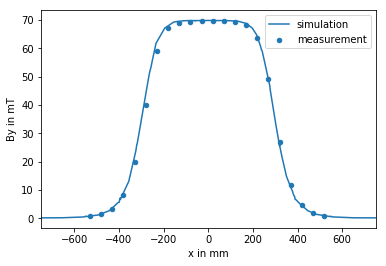

In [96]:
ax = plt.gca()

df_rel.plot(x='dist',y='By', kind = 'scatter',ax=ax)
data_sim.sort_values(0).plot(x=0,y=3,ax=ax)

plt.legend(['simulation','measurement'])

plt.xlabel('x in mm')
plt.ylabel('By in mT')

#plt.xticks(df_rel['dist'])
plt.savefig(r'C:\Users\mrimm\Desktop\COMSOL projects\COSY Bumper\Byvsz_sim_meas.png', format = 'png', dpi=300)
plt.show()

In [70]:
# effective length calc. w/ interpolation of missing data
df_rel['By'].sum()*0.05/df_rel['By'].max()

0.6073001524552685

In [97]:
df_rel['By'].sum()*0.05

42.23547919999999

In [100]:
data_sim_ny = pd.read_csv(r'C:\Users\mrimm\Desktop\COMSOL projects\COSY Bumper\field_map_new_yoke_250A.txt',sep='\s+', skiprows=9,header=None)
data_sim_ny[3] = data_sim_ny[3]*1e3
data_sim_ny[0] = data_sim_ny[0]*1e3
data_sim_ny.head()

,0,1,2,3
0,-750.000000,0,0,0.122709
1,-749.926304,0,0,0.122727
2,-747.177932,0,0,0.124083
3,-747.038169,0,0,0.124075
4,-746.684114,0,0,0.120429


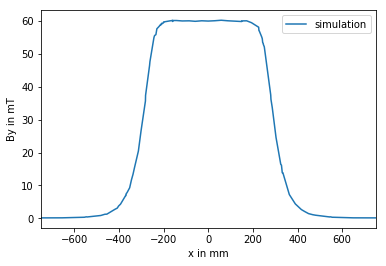

In [108]:
data_sim_ny.sort_values(0).plot(0,3)

plt.legend(['simulation'])

plt.xlabel('x in mm')
plt.ylabel('By in mT')

plt.savefig(r'C:\Users\mrimm\Desktop\COMSOL projects\COSY Bumper\Byvsz_sim_ny.png', format = 'png', dpi=300)
plt.show()

## acceleration cyclotron

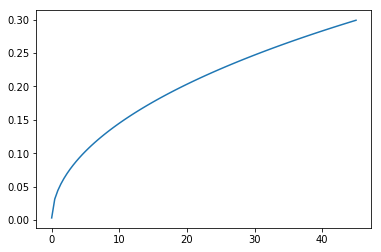

In [7]:
T = np.linspace(4.5e-3,45,100)
beta = np.sqrt(T**2+2*T*938)/(T+938)

plt.plot(T,beta)
#relativistic vel increase

## Eval HFHall meas Bumper

In [3]:
import os

PATH_TO_DIR = r'C:\Users\mrimm\Desktop\MISC\Bumper_HFHall\Magnetfelder'

def get_meas_dfs(path):
    files = os.listdir(path)
    d = {}
    
    for i,file in enumerate(files):
        df = pd.read_csv(os.path.join(path,file) ,sep='\t',skiprows = 8,usecols = [0,1])
        run = file.split('_0_A1_001.asd')[0]
        df['id'] = run
        df['mT'] = df['V'].apply(lambda x: x*1e5/2000) # conversion in mT
        df['Vdiff'] = df['V'].diff()
        
        d[i] = df
        
    return d
    
dfs = get_meas_dfs(PATH_TO_DIR)

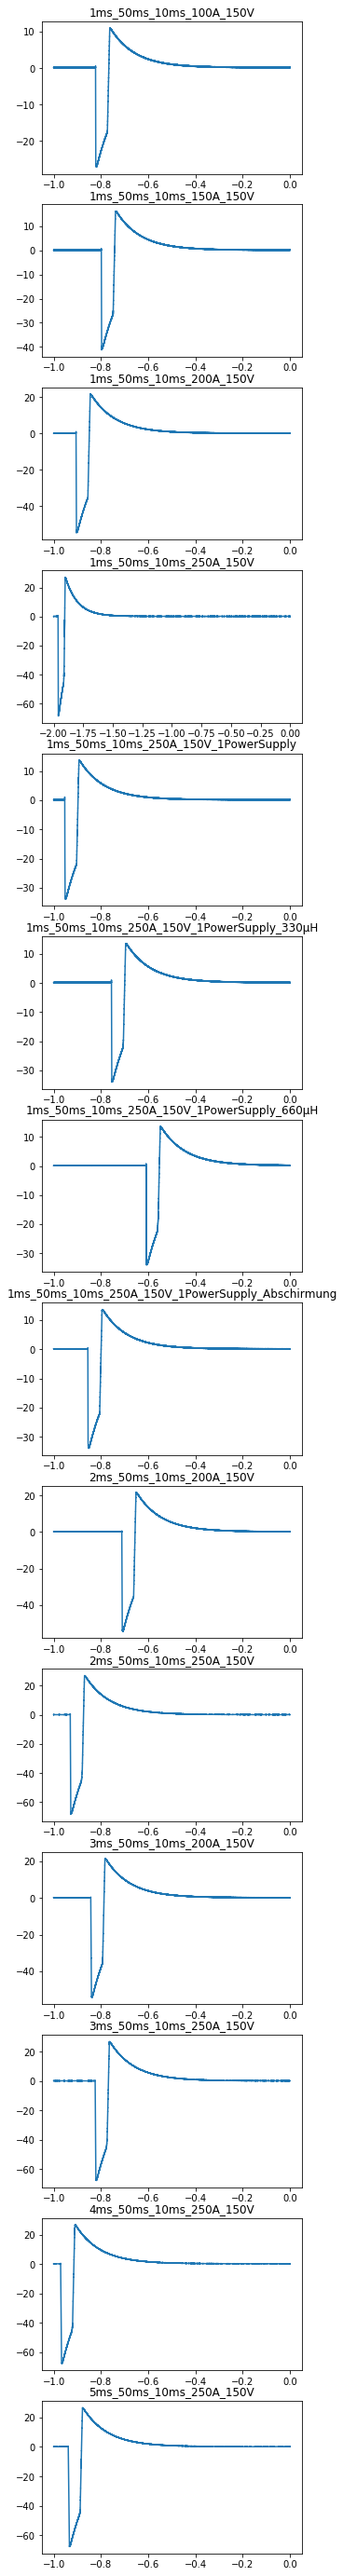

In [49]:
no_dfs = len(dfs.keys())
fig,ax = plt.subplots(no_dfs,1,figsize = (5,50))

data = {}

for i in range(no_dfs):
    df_temp = dfs[i]
    glmin = df_temp['mT'].min()
    s_glmin = df_temp[df_temp['mT'] == glmin]['s'].min()
    df_bf_glmin = df_temp[df_temp['s'] < s_glmin]
    
    start_zero = df_bf_glmin[df_bf_glmin['mT'] == df_bf_glmin['mT'].max()]['s'].min()
    start_10p = df_bf_glmin[df_bf_glmin['mT'] <= glmin*0.1]['s'].min()
    end_90p = df_bf_glmin[df_bf_glmin['mT'] <= glmin*0.9]['s'].min()
    
    ID = df_temp['id'].unique()[0]
    
    full_rt = np.abs(s_glmin-start_zero)
    ten90_rt = np.abs(end_90p-start_10p)
    
    data[ID] = [start_zero,start_10p,end_90p,s_glmin,ten90_rt,full_rt]
    
    ax[i].plot(df_temp['s'],df_temp['mT'])
    ax[i].set_title(ID)

plt.show()

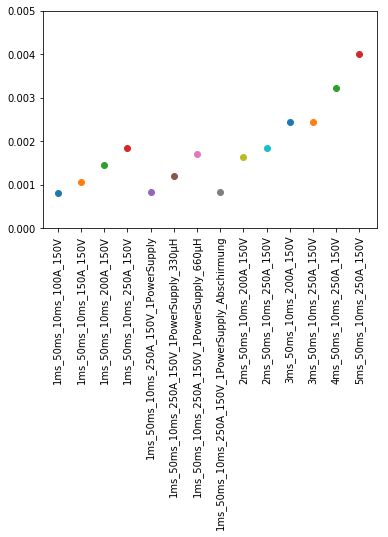

In [50]:
for i in data.keys():
    plt.scatter(i,data[i][4])
    
    
plt.xticks(rotation=90)
plt.ylim([0,0.005])
plt.show()

In [4]:
df_test = dfs[0]
df_test.head()

,s,V,id,mT,Vdiff
0,-0.999999,0.003750,1ms_50ms_10ms_100A_150V,0.187500,NaN
1,-0.999998,0.003437,1ms_50ms_10ms_100A_150V,0.171875,-0.000313
2,-0.999997,0.003437,1ms_50ms_10ms_100A_150V,0.171875,0.000000
3,-0.999996,0.003437,1ms_50ms_10ms_100A_150V,0.171875,0.000000
4,-0.999995,0.002813,1ms_50ms_10ms_100A_150V,0.140625,-0.000625


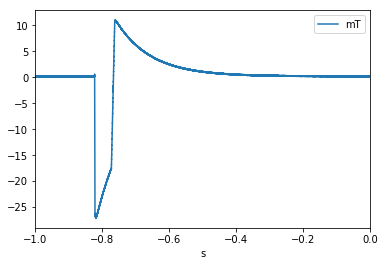

In [5]:
df_test.plot('s','mT')

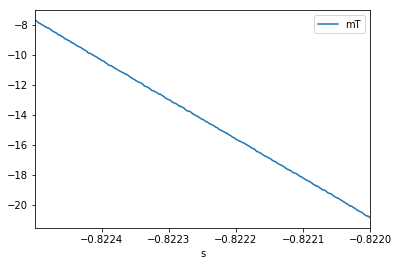

In [99]:
df_int = df_test[(df_test['s'] > -0.8225) & (df_test['s'] < -0.822)]

df_int.plot('s','mT')

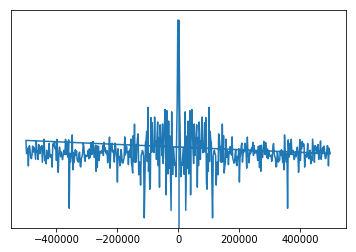

In [101]:
f = np.fft.fftfreq(len(df_int['s']),d=1e-6)
fft = np.fft.fft(df_int['V'])


plt.plot(f,fft.real)
plt.yscale('log')

In [120]:
df_fft = pd.DataFrame({'freq':f,'fft':fft})

df_fft_low = df_fft[(df_fft['freq']<=1e3) | (df_fft['freq']>=-1e3)]
df_fft_high = df_fft[(df_fft['freq']>1e3) | (df_fft['freq']<-1e3)]

df_fft_low.loc[:,'gain'] = df_fft_low['freq'].apply(lambda x: trans_hp_2nd(x,popt_low[0],popt_low[1],popt_low[2]))
df_fft_high.loc[:,'gain'] = df_fft_high['freq'].apply(lambda x: poly(x,popt_high[0],popt_high[1],popt_high[2],popt_high[3]))

df_fft = df_fft_low.append(df_fft_high)

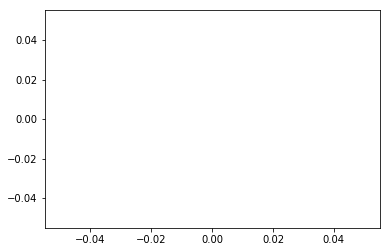

In [122]:
fft_inv = np.fft.ifft(df_fft['fft_cor'].array)
plt.plot(fft_inv.real)

### import gain curve from HF Hall & fit filter fct

In [8]:
trans = pd.read_excel(r'C:\Users\mrimm\Desktop\MISC\Bumper_HFHall\Frequenzgang Hallsensor.xlsx',usecols = [1,4])

In [9]:
def trans_hp_2nd(f,L,R,C):
    w = 2*np.pi*f
    
    return w*L/np.sqrt(R**2+(w*L-1/(w*C))**2)

def poly(x,a,b,c,d):
    
    return a*x+b*x**2+c*x**3+d

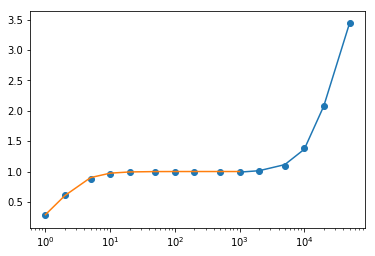

In [10]:
trans_low = trans[trans['f / Hz'] <= 1e3]
popt_low, pcov_low = sco.curve_fit(trans_hp_2nd,trans_low['f / Hz'],trans_low['Gain Gesamt'])

trans_high = trans[trans['f / Hz'] >= 1e3]
popt_high, pcov_high = sco.curve_fit(poly,trans_high['f / Hz'],trans_high['Gain Gesamt'])

plt.plot(trans_high['f / Hz'],poly(trans_high['f / Hz'],popt_high[0],popt_high[1],popt_high[2],popt_high[3]))
plt.plot(trans_low['f / Hz'],trans_hp_2nd(trans_low['f / Hz'],popt_low[0],popt_low[1],popt_low[2]))
plt.scatter(trans['f / Hz'],trans['Gain Gesamt'])
plt.xscale('log')

### Eval LR measurement Bumper

0.6
0.92
1.24
1.56


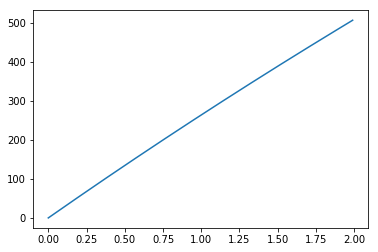

In [123]:
t = np.arange(0,2,0.01)
I = 150e3/40.5*(1-np.exp(-t*40.5/547))
currs = [200,300,400,500]
for c in currs:
    start = [t for t,i in enumerate(I) if i >=0.1*c][0]
    final = [t for t,i in enumerate(I) if i >=0.9*c][0]
    print((final-start)/100)

plt.plot(t,I)


23.8 393.4 0.54
43.400000000000006 723.4 1.0
63.0 1053.4 1.48


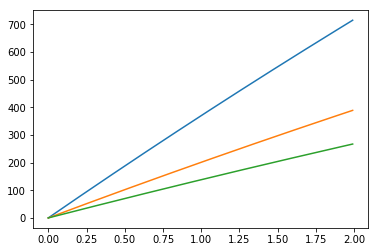

In [95]:
Ls = [393.4,393.4+330,393.4+660]
Rs = [23.8,23.8+19.6,23.8+2*19.6]

for R,L in zip(Rs,Ls):
    
    I_1PS = 150e3/R*(1-np.exp(-t*R/L))
    plt.plot(t,I_1PS)
    
    start = [t for t,i in enumerate(I_1PS) if i >=0.1*250][0]
    final = [t for t,i in enumerate(I_1PS) if i >=0.9*250][0]
    print(R,L,(final-start)/100)

plt.show()

In [87]:
one_PS_ids = [i for i in data.keys() if '1PowerSupply' in i][:3]
meas = [data[i][4] for i in one_PS_ids] 
meas

[0.0008260000000001044, 0.0011900000000000244, 0.0017140000000001043]

In [93]:
print(meas[1]/meas[0],1/0.54)
print(meas[2]/meas[0],1.48/0.54)

1.4406779661015423 1.8518518518518516
2.075060532687515 2.7407407407407405


0.8059999999999734
1.0729999999999906
1.4529999999998156
1.8460000000000143
0.8260000000001044
1.1900000000000244
1.7140000000001043


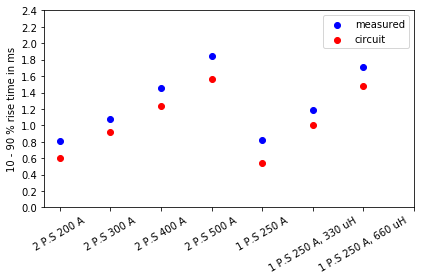

In [157]:
to_plot = list(data.keys())[:7]

t_circ = [0.6,0.92,1.24,1.56,0.54,1,1.48]

for i,j in enumerate(to_plot):
    plt.scatter(j,data[j][4]*1e3,c='b')
    plt.scatter(j,t_circ[i],c='r')
    print(data[j][4]*1e3)
    
plt.legend(['measured','circuit'])  
label = ('2 P.S 200 A','2 P.S 300 A','2 P.S 400 A','2 P.S 500 A','1 P.S 250 A','1 P.S 250 A, 330 uH','1 P.S 250 A, 660 uH')
plt.xticks(ticks = range(8),labels = label,rotation=30)
plt.ylabel('10 - 90 % rise time in ms')
plt.yticks(np.arange(0,2.5,0.2))


plt.tight_layout()
plt.savefig(r'C:\Users\mrimm\Desktop\COMSOL projects\COSY Bumper\rise_times.png', format = 'png', dpi=300)
plt.show()

### calc the rms current value in the bumper 

In [208]:
np.sqrt(200*(2/3*500**2*(1e-3)**2 + 500**2*0.4e-3))

141.53915830374766

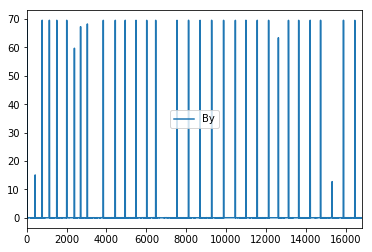

In [7]:
data_pos = pd.read_csv(r'C:/Users/mrimm/Desktop/MISC/250A_10ms_50ms_10ms_pos.txt',sep='\t')

data_pos['Timestamp'] = data_pos['Timestamp'].apply(lambda x: datetime.strptime(x[:26],'%Y.%m.%d %H:%M:%S.%f'))

data_pos['By'] = data_pos['By'].apply(lambda x: -x)

data_pos.plot(y='By')

In [10]:
data_pos

,Block,B,Bx,By,Bz,Units,Temperature,Timestamp,Serial No.,Comment
0,0,0.060745,-0.024522,0.052014,-0.019577,MT,20390,2019-12-13 11:51:35.120094,1065,NaN
1,0,0.098311,-0.062324,0.064107,-0.040878,MT,20390,2019-12-13 11:51:35.130094,1065,NaN
2,0,0.066227,0.013523,0.063807,-0.011481,MT,20390,2019-12-13 11:51:35.140094,1065,NaN
3,0,0.060860,-0.041688,0.044319,0.001402,MT,20390,2019-12-13 11:51:35.150094,1065,NaN
4,0,0.063119,-0.015455,0.051836,-0.032529,MT,20390,2019-12-13 11:51:35.160094,1065,NaN
5,0,0.071063,-0.032660,0.060399,0.018310,MT,20390,2019-12-13 11:51:35.170094,1065,NaN
6,0,0.069807,-0.020405,0.055838,-0.036589,MT,20390,2019-12-13 11:51:35.180094,1065,NaN
7,0,0.078518,-0.049780,0.052626,0.030290,MT,20390,2019-12-13 11:51:35.190094,1065,NaN
8,0,0.066671,-0.028572,0.060223,0.001332,MT,20390,2019-12-13 11:51:35.200094,1065,NaN
9,0,6.779073,0.019604,6.740045,-0.726114,MT,20390,2019-12-13 11:51:35.210094,1065,NaN
